<a href="https://colab.research.google.com/github/Moarcas/licenta/blob/master/code/models/modelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [165]:
from google.colab import drive

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from tqdm import tqdm

## Mount google drive

In [166]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Select device

In [167]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Training on", device)

Training on cuda


## Dataset class

In [168]:
class AudioDataset(Dataset):
    def __init__(self, data_filepath, labels_filepath):
        self.data = np.load(data_filepath)
        self.data = np.expand_dims(self.data, axis=1)
        self.labels = np.load(labels_filepath)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
        return data, label

features_path = '/content/drive/MyDrive/licenta/arrays/mfcc_features.npy'
labels_path = '/content/drive/MyDrive/licenta/arrays/labels.npy'
dataset = AudioDataset(data_filepath=features_path, labels_filepath=labels_path)

## Normalize function

In [169]:
def normalize(data):
    data = (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))
    return data

## Dataloader

In [170]:
# split the dataset into three parts (train 70%, test 15%, validation 15%)
test_size = 0.15
val_size = 0.15

test_amount, val_amount = int(dataset.__len__() * test_size), int(dataset.__len__() * val_size)

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [
            (dataset.__len__() - (test_amount + val_amount)),
            test_amount,
            val_amount
])

# train_set.dataset.data = normalize(train_set.dataset.data)
# val_set.dataset.data = normalize(val_set.dataset.data)
# test_set.dataset.data = normalize(test_set.dataset.data)

B = 64

train_dataloader = torch.utils.data.DataLoader(
            train_set,
            batch_size=B,
            shuffle=True,
            drop_last=True,
)
val_dataloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=B,
            shuffle=False,
            drop_last=True,
)
test_dataloader = torch.utils.data.DataLoader(
            test_set,
            batch_size=B,
            shuffle=False,
            drop_last=True,
)

## Train/eval functions

In [171]:
def train_epoch(model, train_dataloader, loss_crt, optimizer, device):
    """
    model: Model object
    train_dataloader: DataLoader over the training dataset
    loss_crt: loss function object
    optimizer: Optimizer object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns:
     - the epoch training loss, which is an average over the individual batch
       losses
    """
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = len(train_dataloader)

    for batch_idx, batch in enumerate(train_dataloader):
        # shape: batch_size x 1 x 13 x 345, batch_size
        batch_data, batch_labels = batch

        # move data to GPU
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # initialize as zeros all the gradients of the model
        model.zero_grad()

        # get predictions from the FORWARD pass
        # shape: batch_size x 9
        output = model(batch_data)

        loss = loss_crt(output, batch_labels.squeeze())
        loss_scalar = loss.item()

        # BACKPROPAGATE the gradients
        loss.backward()
        # use the gradients to OPTIMISE the model
        optimizer.step()

        epoch_loss += loss_scalar

        pred = output.argmax(dim=1, keepdim=True)
        epoch_accuracy += pred.eq(batch_labels.view_as(pred)).float().mean().item()

    epoch_loss = epoch_loss / num_batches
    epoch_accuracy = 100. * epoch_accuracy / num_batches
    return epoch_loss, epoch_accuracy

def eval_epoch(model, val_dataloader, loss_crt, device):
    """
    model: Model object
    val_dataloader: DataLoader over the validation dataset
    loss_crt: loss function object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns:
     - the epoch validation loss, which is an average over the individual batch
       losses
    """
    model.eval()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = len(val_dataloader)
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(val_dataloader)):
            # shape: batch_size x 1 x 13 x 345, batch_size
            batch_data, batch_labels = batch

            # move data to GPU
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            # batch_size x 10
            output = model(batch_data)

            loss = loss_crt(output, batch_labels.squeeze())
            loss_scalar = loss.item()

            epoch_loss += loss_scalar

            pred = output.argmax(dim=1, keepdim=True)
            epoch_accuracy += pred.eq(batch_labels.view_as(pred)).float().mean().item()

    epoch_loss = epoch_loss/num_batches
    epoch_accuracy = 100. * epoch_accuracy/num_batches
    return epoch_loss, epoch_accuracy

## Model class

In [172]:
class AccentClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)
        self.fc1 = nn.Linear(in_features = 5376, out_features = 512)
        self.fc2 = nn.Linear(in_features = 512, out_features = 9)
        self.activation_fn = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.activation_fn(self.conv1(x))
        x = self.pool(x)
        x = self.activation_fn(self.conv2(x))
        x = self.pool(x)
        x = x.view(B, -1)
        x = self.dropout(x)
        x = self.activation_fn(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = AccentClassifier().to(device)

## Hyperparameters

In [173]:
hyperparams = {
    'lr': 5e-4,
    'num_epochs': 30,
    'optimizer': "adam",
    'momentum': 0.9,
}

loss_criterion = nn.CrossEntropyLoss()

if hyperparams['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=hyperparams['lr']
    )
elif hyperparams['optimizer'] == 'sgd':
    optimizer = torch.optim.SGD(
        params=model.parameters(),
        lr=hyperparams['lr'],
        momentum=hyperparams['momentum']
    )

## Train loop

In [174]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, hyperparams['num_epochs'] + 1):
    train_loss, train_accuracy = train_epoch(model, train_dataloader, loss_criterion, optimizer, device)
    val_loss, val_accuracy = eval_epoch(model, val_dataloader, loss_criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print('\nEpoch %d'%(epoch))
    print('train loss: %10.8f, accuracy: %10.8f'%(train_loss, train_accuracy))
    print('val loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy))


40it [00:00, 320.79it/s]



Epoch 1
train loss: 1.55479664, accuracy: 52.67857143
val loss: 0.58227188, accuracy: 77.96875000


40it [00:00, 302.45it/s]



Epoch 2
train loss: 0.55530229, accuracy: 78.67063492
val loss: 0.29945592, accuracy: 89.72656250


40it [00:00, 298.42it/s]



Epoch 3
train loss: 0.35405488, accuracy: 87.23544974
val loss: 0.30529047, accuracy: 88.51562500


40it [00:00, 274.57it/s]



Epoch 4
train loss: 0.24582571, accuracy: 91.15410053
val loss: 0.19811056, accuracy: 92.77343750


40it [00:00, 324.40it/s]



Epoch 5
train loss: 0.19329811, accuracy: 93.12169312
val loss: 0.14178462, accuracy: 95.03906250


40it [00:00, 328.37it/s]



Epoch 6
train loss: 0.16825644, accuracy: 93.89054233
val loss: 0.14503600, accuracy: 94.80468750


40it [00:00, 327.82it/s]



Epoch 7
train loss: 0.13510951, accuracy: 95.26289683
val loss: 0.11565717, accuracy: 95.82031250


40it [00:00, 329.33it/s]



Epoch 8
train loss: 0.13795524, accuracy: 95.19675926
val loss: 0.14742647, accuracy: 95.15625000


40it [00:00, 322.68it/s]



Epoch 9
train loss: 0.10375586, accuracy: 96.41203704
val loss: 0.09496525, accuracy: 96.91406250


40it [00:00, 317.22it/s]



Epoch 10
train loss: 0.09178609, accuracy: 96.87500000
val loss: 0.10851566, accuracy: 96.25000000


40it [00:00, 290.96it/s]



Epoch 11
train loss: 0.08145534, accuracy: 97.16435185
val loss: 0.06984932, accuracy: 97.85156250


40it [00:00, 288.83it/s]



Epoch 12
train loss: 0.08295744, accuracy: 97.00727513
val loss: 0.10459153, accuracy: 96.52343750


40it [00:00, 326.44it/s]



Epoch 13
train loss: 0.06857926, accuracy: 97.61904762
val loss: 0.07928695, accuracy: 97.61718750


40it [00:00, 322.27it/s]



Epoch 14
train loss: 0.07075721, accuracy: 97.65211640
val loss: 0.07871771, accuracy: 97.81250000


40it [00:00, 331.83it/s]



Epoch 15
train loss: 0.07607515, accuracy: 97.39583333
val loss: 0.06728864, accuracy: 98.04687500


40it [00:00, 315.52it/s]



Epoch 16
train loss: 0.06443964, accuracy: 97.75132275
val loss: 0.08055800, accuracy: 97.61718750


40it [00:00, 317.93it/s]



Epoch 17
train loss: 0.05402703, accuracy: 98.12334656
val loss: 0.06361154, accuracy: 98.28125000


40it [00:00, 330.61it/s]



Epoch 18
train loss: 0.06585822, accuracy: 97.89186508
val loss: 0.07957480, accuracy: 97.57812500


40it [00:00, 281.42it/s]



Epoch 19
train loss: 0.05146496, accuracy: 98.13988095
val loss: 0.08128704, accuracy: 98.04687500


40it [00:00, 282.54it/s]



Epoch 20
train loss: 0.06798084, accuracy: 97.87533069
val loss: 0.08073689, accuracy: 97.65625000


40it [00:00, 329.75it/s]



Epoch 21
train loss: 0.06002173, accuracy: 97.99107143
val loss: 0.06975328, accuracy: 98.08593750


40it [00:00, 331.86it/s]



Epoch 22
train loss: 0.04215125, accuracy: 98.65244709
val loss: 0.10050077, accuracy: 97.38281250


40it [00:00, 326.68it/s]



Epoch 23
train loss: 0.04324679, accuracy: 98.53670635
val loss: 0.10521168, accuracy: 97.46093750


40it [00:00, 318.14it/s]



Epoch 24
train loss: 0.04796548, accuracy: 98.46230159
val loss: 0.08508289, accuracy: 97.57812500


40it [00:00, 311.47it/s]



Epoch 25
train loss: 0.05111297, accuracy: 98.23908730
val loss: 0.07215765, accuracy: 98.28125000


40it [00:00, 326.47it/s]



Epoch 26
train loss: 0.05259201, accuracy: 98.42096561
val loss: 0.06750662, accuracy: 98.16406250


40it [00:00, 286.42it/s]



Epoch 27
train loss: 0.04456769, accuracy: 98.43750000
val loss: 0.06246507, accuracy: 98.67187500


40it [00:00, 278.85it/s]



Epoch 28
train loss: 0.04180716, accuracy: 98.71031746
val loss: 0.06614530, accuracy: 98.39843750


40it [00:00, 327.21it/s]



Epoch 29
train loss: 0.06373287, accuracy: 97.97453704
val loss: 0.09052284, accuracy: 97.50000000


40it [00:00, 321.57it/s]


Epoch 30
train loss: 0.04888213, accuracy: 98.60284392
val loss: 0.07284088, accuracy: 98.12500000


## Test accuracy

In [175]:
test_loss, test_accuracy = eval_epoch(model, test_dataloader, loss_criterion, device)
print('test loss: %10.8f, accuracy: %10.8f'%(test_loss, test_accuracy))

40it [00:00, 293.17it/s]

test loss: 0.10788644, accuracy: 97.18750000


In [176]:
def get_predictions_and_labels(model, dataloader, device):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(val_dataloader)):
            batch_mfcc, batch_labels = batch

            # move data to GPU
            batch_mfcc = batch_mfcc.to(device)
            batch_labels = batch_labels.to(device)

            # batch_size x 10
            output = model(batch_mfcc)

            predictions.append(output.argmax(dim=1, keepdim=True))
            labels.append(batch_labels)

    predictions = torch.cat(predictions, dim=0)
    labels = torch.cat(labels, dim=0)

    return predictions, labels

## Confusion matrix

In [177]:
predictions, labels = get_predictions_and_labels(model, test_dataloader, device)
cm = confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy())

40it [00:00, 463.09it/s]


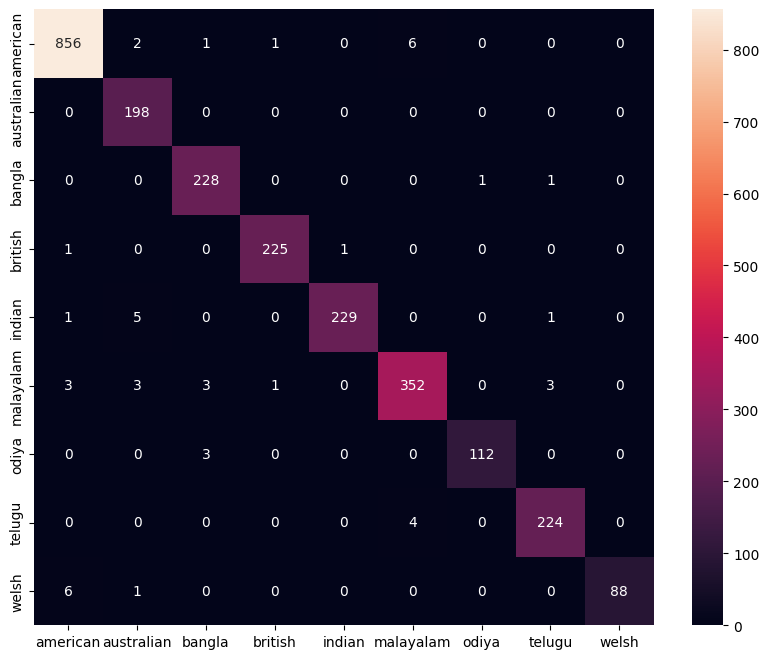

In [178]:
labels = ["american", "australian", "bangla", "british", "indian", "malayalam", "odiya", "telugu", "welsh"]

df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10, 8))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.savefig('/content/drive/MyDrive/licenta/confustionMatrix')

## Accuracy and loss plot

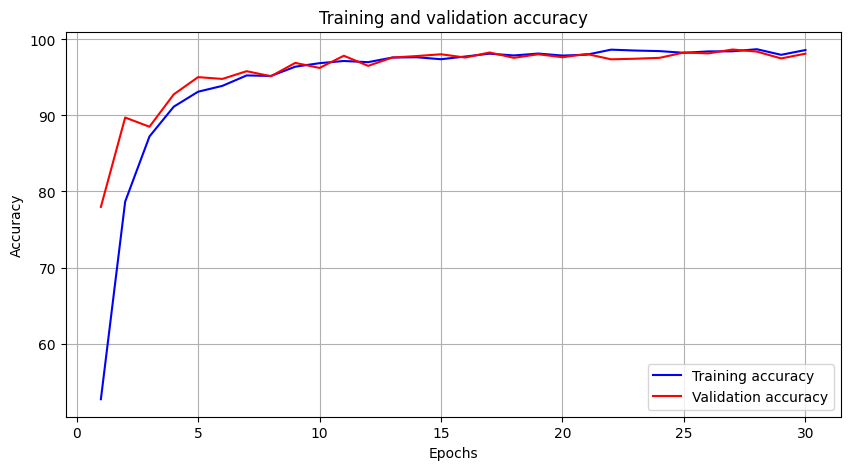

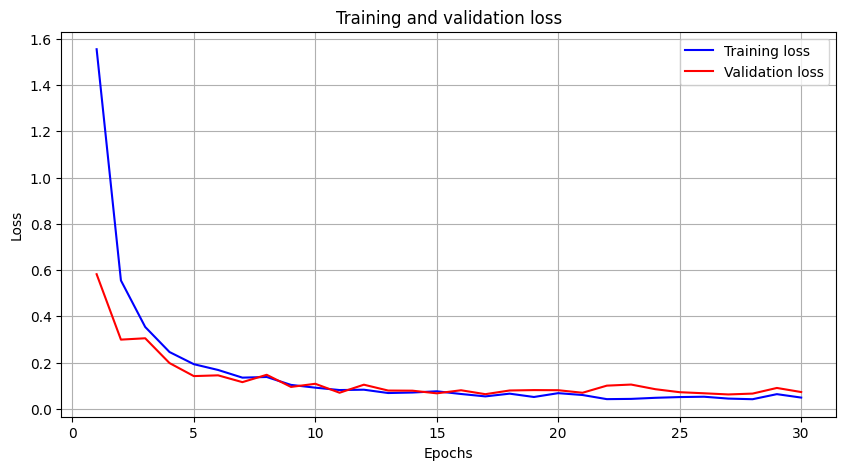

In [179]:
# Data
epochs = range(1, 31)

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()